<a href="https://colab.research.google.com/github/myke11j/kaggle-competetions/blob/master/LANL-Earthquake-Prediction/kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install kaggle
! pip install catboost
! pip install numpy

     |████████████████████████████████| 61.2MB 613kB/s 


# **Import libraries**

In [0]:
# for data processing and maths operation
import pandas as pd
import numpy as np

# for ML model
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR, NuSVR

# for scaling
from sklearn.preprocessing import StandardScaler

# for hyper model tuning
from sklearn.model_selection import GridSearchCV

# for kernel grid
from sklearn.kernel_ridge import KernelRidge

# for visualisation
import matplotlib.pyplot as plt

In [6]:
print(pd.__version__)
print(np.__version__)

0.24.2
1.16.4


# **Import files**

In [7]:
from google.colab import files
uploaded = files.upload()

! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/': No such file or directory


In [8]:
# kaggle competeion list
! kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3101           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11559            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4506            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         46           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3611           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [9]:
# Download the dataset

! kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 12.9MB/s]
 98% 238M/242M [00:01<00:00, 171MB/s]
100% 242M/242M [00:01<00:00, 168MB/s]
100% 2.02G/2.03G [00:36<00:00, 75.2MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.8MB/s]


In [30]:
# check if data is there mow
!mkdir test
# !unzip test.zip -d test/
# !unzip train.csv.zip
!ls

mkdir: cannot create directory ‘test’: File exists
Archive:  test.zip
  inflating: test/seg_430e66.csv     
  inflating: test/seg_d1a281.csv     
  inflating: test/seg_05a1b0.csv     
  inflating: test/seg_f8dd7e.csv     
  inflating: test/seg_b9bdd7.csv     
  inflating: test/seg_24c1c9.csv     
  inflating: test/seg_c5abaa.csv     
  inflating: test/seg_6262c4.csv     
  inflating: test/seg_734a88.csv     
  inflating: test/seg_94a133.csv     
  inflating: test/seg_d0c280.csv     
  inflating: test/seg_d36737.csv     
  inflating: test/seg_f80e44.csv     
  inflating: test/seg_07c815.csv     
  inflating: test/seg_7c9433.csv     
  inflating: test/seg_211486.csv     
  inflating: test/seg_78ded2.csv     
  inflating: test/seg_f11f77.csv     
  inflating: test/seg_b3883e.csv     
  inflating: test/seg_3db0a8.csv     
  inflating: test/seg_81f798.csv     
  inflating: test/seg_0a45a1.csv     
  inflating: test/seg_dc188b.csv     
  inflating: test/seg_4a9e8d.csv     
  inflating: test/

# **Data Analysis**

In [0]:

#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

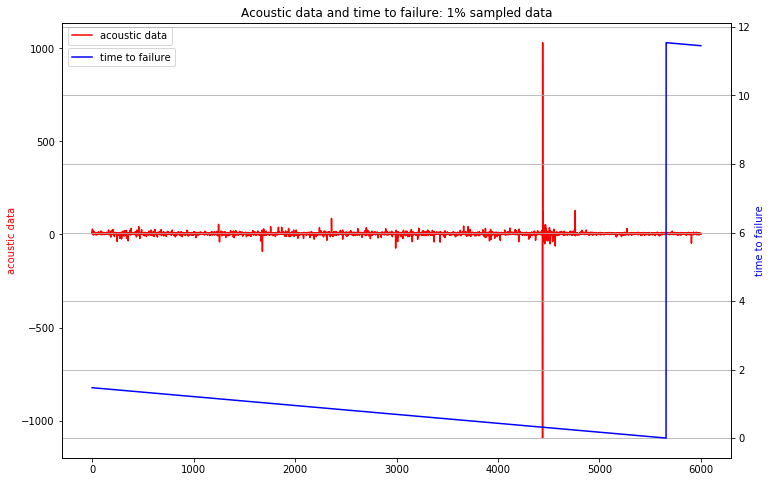

In [14]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::1000]
train_ttf_sample_df = train['time_to_failure'].values[::1000]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Feature **Enginnering**

In [0]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [17]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [20]:
train_pool = Pool(X_train, y_train)

# for interation in list([100, 5000, 10000, 20000]):
#   m = CatBoostRegressor(iterations=interation, loss_function='MAE', boosting_type='Ordered')
#   m.fit(X_train, y_train, silent=True)
#   print('Iteration {}, {}'.format(interation, m.best_score_))

m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
print('Iteration {}, {}'.format(10000, m.best_score_))

Iteration 10000, {'learn': {'MAE': 1.7836623258199857}}


In [0]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')


In [0]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [0]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [32]:
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,ave,std,max,min
seg_id,,,,,,,,,,,,,,,,,
seg_00030f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.491780,4.893673,115.0,-75.0
seg_0012b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.171153,5.922820,152.0,-140.0
seg_00184e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.610260,6.946967,248.0,-193.0
seg_003339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.531473,4.114133,85.0,-93.0
seg_0042cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.128340,5.797144,177.0,-147.0
seg_004314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.148607,24.782686,671.0,-675.0
seg_004cd2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.113987,4.707134,125.0,-107.0
seg_004ee5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.328380,5.964423,120.0,-120.0
seg_004f1f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000733,5.874450,118.0,-114.0


In [33]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.00,-2.0,11.0,18.00,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.00,-2.0,12.0,21.00,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.00,-3.0,13.0,26.00,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.00,-2.0,12.0,22.00,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.00,-2.0,12.0,26.00,145.0,6.110587,6.329485
5,4.913513,5.434111,-144.0,142.0,50.215147,-0.100697,-10.00,-2.0,12.0,19.00,144.0,5.695167,4.608383
6,4.855660,5.687823,-78.0,120.0,23.173004,0.208810,-12.00,-2.0,12.0,21.00,120.0,5.791007,4.732118
7,4.505427,5.854512,-134.0,139.0,52.388738,-0.176333,-11.00,-2.0,11.0,20.00,139.0,5.415000,5.025126
8,4.717833,7.789643,-156.0,168.0,65.360261,-0.160166,-16.00,-3.0,13.0,26.00,168.0,6.152273,6.714605
9,4.730960,6.890459,-126.0,152.0,53.760207,0.150779,-14.00,-3.0,12.0,23.00,152.0,5.925120,5.895191
